# Análise de Vídeo de Alta Velocidade: Frequência do Movimento das Asas de uma Mosca.

Determinação da frequência do movimento das asas de uma mosca registrado em vídeo de alta velocidade a 4000 fps (quadros por segundo).

O vídeo foi registrado com uma câmera modelo iSpeed 3 equipada com lente Nikkor 58mm f/1.2. Os dados de rastreio de movimento foram obtidos no software Tracker v 5.1.4 e analisados na ferramenta Data Tool $\textit{(View>Data Tool (Analyze...))}$ do próprio Tracker e externamente em Python 3.

### Análise dos Dados (Tracker)

![Tracker_Mosca.png](Tracker_Mosca.png)
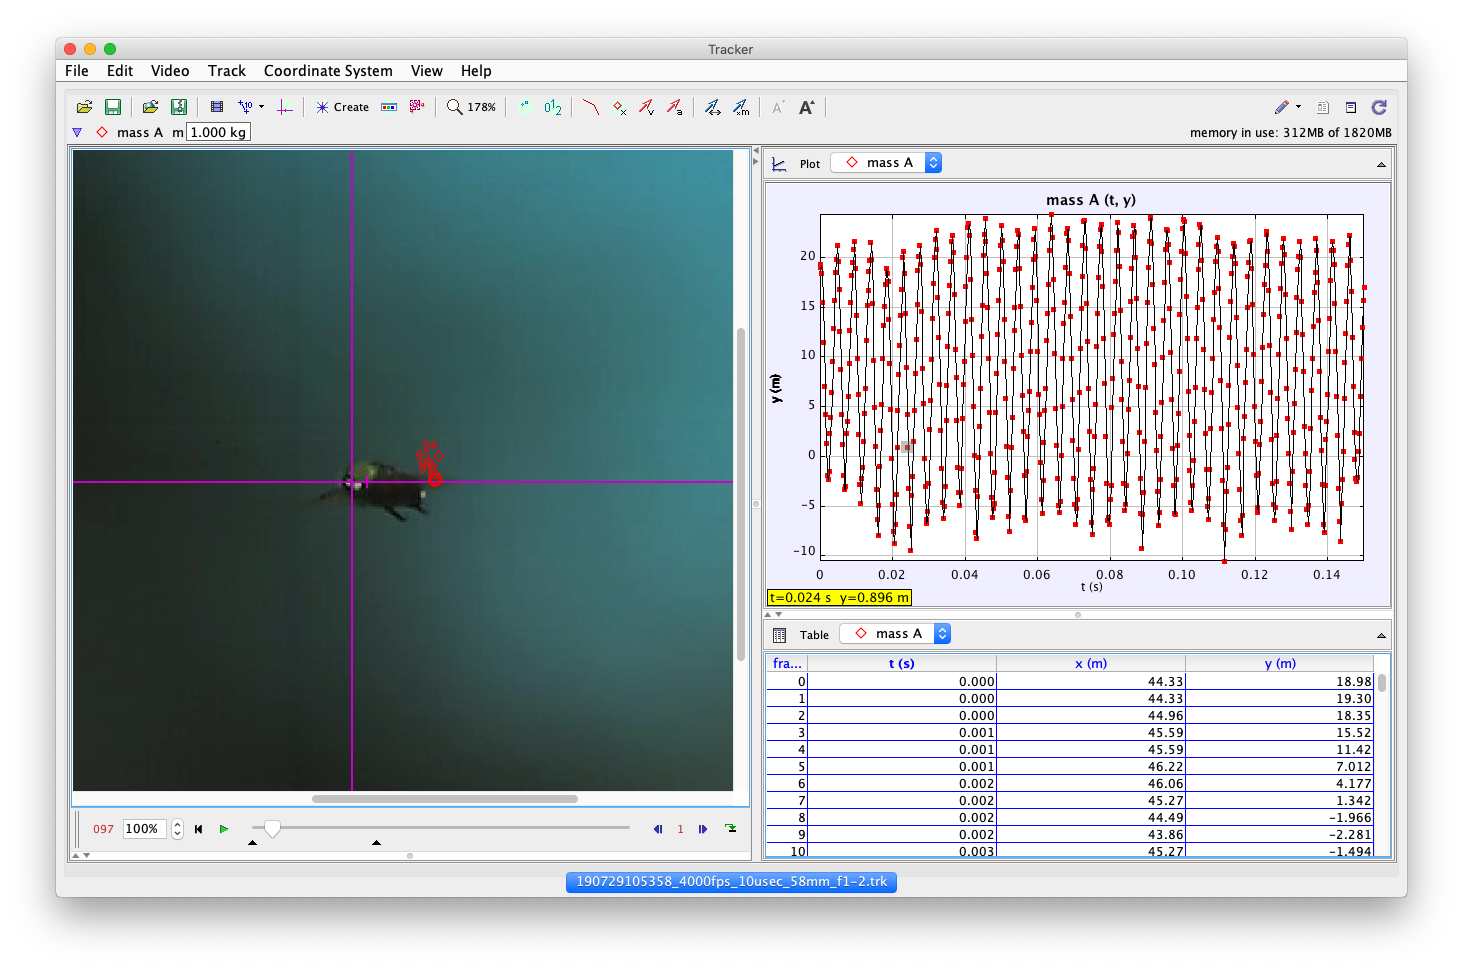

A origem do sistema de coordenadas foi fixada na cabeça do inseto e move-se com ele durante o voo.
Um ponto da asa equerda foi rastreado manualmente durante 600 quadros de vídeo (150 ms). A frequência do movimento das asas foi determinada diretamente no espectro de Fourier da ferramenta de análise do próprio Tracker, que encontrou como predominante uma componente de 220 Hz (A componente de 0 Hz é, obviamente, descartada por se tratar de um efeito do deslocamento da origem do sistema de coordenadas).

![Tracker_Fourier.png](Tracker_Fourier.png)
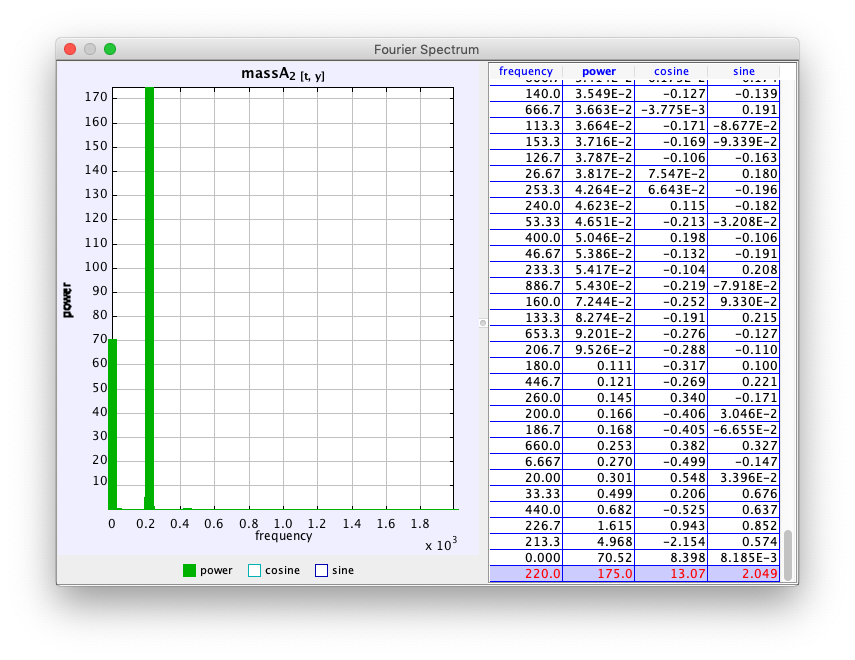

### Análise dos Dados (Python 3)

Os dados exportados do Tracker foram exportados em formato csv e analisados externamente encontrando resultados similares.

Apresentamos nossa análise utilizando Python 3 (orientado a gambiarras) para determinação da frequência da batida das asas.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.signal import find_peaks

#Cria o DataFrame 'Dados de Voo' a partir do arquivo 'FlyWingbeat.csv' exportado do Tracker.
Mosca_Asa = pd.DataFrame(pd.read_csv('Mosca_Asa.csv'))

#Usa a coluna 'frame' como index.
Mosca_Asa = Mosca_Asa.set_index('frame')

#Exibe as primeiras linhas do DataFrame para inspeção.
Mosca_Asa.head()

,t,x,y
frame,,,
0.0,0.00000,44.328517,18.983086
1.0,0.00025,44.328517,19.298112
2.0,0.00050,44.958569,18.353034
3.0,0.00075,45.588621,15.517801
4.0,0.00100,45.588621,11.422464


Estamos interessados apenas no movimento ao longo do eixo vertical (y).
Encontraremos o valor médio da posição vertical da asa para estabelecer uma nova origem para o eixo Y e plotaremos os dados de posição em y versus tempo.

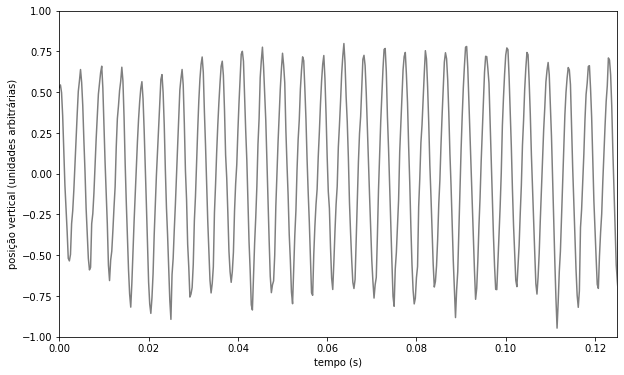

In [2]:
#Encontra o valor médio de y para estabelecer uma nova origem do eixo vertical
Y_zero = Mosca_Asa['y'].mean()
Mosca_Asa['y'] = Mosca_Asa['y']-Y_zero

#Plota dados
fig = plt.figure(figsize = (10,6))
plt.xlabel('tempo (s)')
plt.ylabel('posição vertical (unidades arbitrárias)')
plt.xlim(-0,0.125)
plt.ylim(-1,1)
plt.plot(Mosca_Asa['t'],Mosca_Asa['y']/20, color='k', alpha=0.5)

Vemos que o gráfico é bem comportado e que o período não apresenta irregularidades.
As unidades de comprimento não foram calibradas no vídeo, mas são irrelevantes para determinação da frequência.

No gráfico, exibimos a amplitude em unidades arbitrárias. O valor dos dados de posição ['y'] da tabela foram divididos pelo fator 20 para permitir um eixo Y com limites (-1,+1).

Encontraremos a frequência medindo o período entre os picos positivos. Criaremos uma cópia do DataFrame original para computar estes dados.


In [3]:
#Encontra os picos para determinação da frequência
#Cria uma copia do DataFrame
Mosca_Asa_picos = Mosca_Asa.copy(deep=True)
#Procura os picos de 'y' acima do 0.
picos_y, _ = find_peaks(Mosca_Asa_picos['y'], height=0)
#Cria a coluna 'picos' com os valores encontrados
Mosca_Asa_picos['picos'] = Mosca_Asa.y[picos_y]
#Exclui as linhas onde não ocorrem picos
Mosca_Asa_picos.dropna(axis=0, how='any', inplace=True)
#Reseta o index (vamos usar isso em nossa lógica)
Mosca_Asa_picos.reset_index(drop=True, inplace=True)

Determinamos o período do i-ésimo ciclo computando a metade do intervalo entre os ciclos (i+1) e (i-1):

$T_i = \frac{t_(i+1) - t_(i-1)}{2}$

A frequência instantânea no i-ésimo pico é o inverso do período encontrado pelo método descrito acima.

$f_i = \frac{1}{T_i} = \frac{2}{t_(i+1) - t_(i-1)}$

Não estão definidas, por este método, as frequências do primeiro e do último ciclo.

In [4]:
ultimo_quadro = Mosca_Asa_picos['picos'].count() - 1
for i in range(1, ultimo_quadro):
    Mosca_Asa_picos.at[i, 'frequencia'] = 2/(Mosca_Asa_picos.at[i + 1, 't'] - Mosca_Asa_picos.at[i - 1, 't'])
    
Mosca_Asa_picos.head()

,t,x,y,picos,frequencia
0,0.00025,44.328517,10.887180,10.887180,NaN
1,0.00475,47.478776,12.777335,12.777335,216.216216
2,0.00950,47.904859,13.188929,13.188929,216.216216
3,0.01400,47.877781,13.061306,13.061306,222.222222
4,0.01850,47.540937,11.286805,11.286805,222.222222


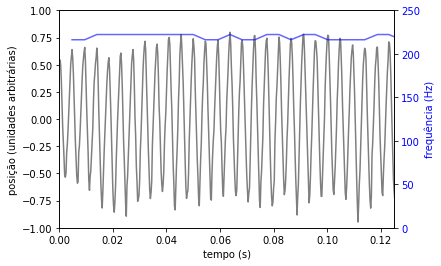

<Figure size 720x432 with 0 Axes>

In [5]:
fig, ax1 = plt.subplots()

ax1.set_xlabel('tempo (s)')
ax1.set_ylabel('posição (unidades arbitrárias)', color='k')
plt.ylim(-1,1) #limites do eixo Y para o primeiro plot
plt.xlim(0,0.125) #limite do eixo X (comum aos dois plots)
ax1.plot(Mosca_Asa['t'],Mosca_Asa['y']/20, color='k', alpha=0.5)
ax1.tick_params(axis='y', labelcolor='k')

ax2 = ax1.twinx() #duplica o eixo X para ambos os plots

ax2.set_ylabel('frequência (Hz)', color='b')
plt.ylim(0,250)
ax2.plot(Mosca_Asa_picos['t'], Mosca_Asa_picos['frequencia'], color='b', alpha=0.6)
ax2.tick_params(axis='y', labelcolor='b')

fig = plt.figure(figsize = (10,6))
fig.tight_layout()
plt.show()

Analisando os dados da coluna 'frequencia' no DataFrame encontramos um valor médio de 219.7 Hz com desvio padrão de 3.0 Hz.

In [6]:
Mosca_Asa_picos['frequencia'].describe()

count     31.000000
mean     219.703575
std        3.012675
min      216.216216
25%      216.216216
50%      222.222222
75%      222.222222
max      222.222222
Name: frequencia, dtype: float64

## Conclusão

A velocidade média da batida de asas da mosca observada no vídeo é de 220 Hz $\pm$ 3 Hz com resultados obtidos através de dois métodos de análise concordando entre si. Os procedimentos assim validados abrem possibilidades para a solução de problemas importantes da física de voo de insetos e aves em geral e, em particular, do enigma da velocidade de voo de uma andorinha solteira (africana ou europeia).